In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
from pathlib import Path
import zipfile
import requests

data_path = Path("data/")
image_path = data_path / "faces"
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    with open(data_path / "archive.zip", "wb") as f:
        request = requests.get("https://github.com/HoussemBeltifa/Mood_Detection/raw/main/archive.zip")
        print("Downloading data...")
        f.write(request.content)

    with zipfile.ZipFile(data_path / "archive.zip", "r") as zip_ref:
        print("Unzipping data...") 
        zip_ref.extractall(image_path)


Did not find data/faces directory, creating one...
Unzipping data...


In [4]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
walk_through_dir(image_path)

There are 1 directories and 0 images in 'data/faces'.
There are 2 directories and 0 images in 'data/faces/data'.
There are 7 directories and 0 images in 'data/faces/data/train'.
There are 0 directories and 7215 images in 'data/faces/data/train/happy'.
There are 0 directories and 4830 images in 'data/faces/data/train/sad'.
There are 0 directories and 4360 images in 'data/faces/data/train/disgusted'.
There are 0 directories and 4965 images in 'data/faces/data/train/neutral'.
There are 0 directories and 3995 images in 'data/faces/data/train/angry'.
There are 0 directories and 3171 images in 'data/faces/data/train/surprised'.
There are 0 directories and 4097 images in 'data/faces/data/train/fearful'.
There are 7 directories and 0 images in 'data/faces/data/test'.
There are 0 directories and 1774 images in 'data/faces/data/test/happy'.
There are 0 directories and 1247 images in 'data/faces/data/test/sad'.
There are 0 directories and 999 images in 'data/faces/data/test/disgusted'.
There are 

In [6]:
# Setup train and testing paths
train_dir = image_path / "data" / "train"
test_dir = image_path / "data" / "test"

train_dir, test_dir

(PosixPath('data/faces/data/train'), PosixPath('data/faces/data/test'))

Random image path: data/faces/data/train/sad/im1791.png
Image class: sad
Image height: 48
Image width: 48


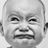

In [7]:
import random
from PIL import Image

# Set seed
random.seed(42) 

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*/*.png"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

In [8]:
# Write transform for image
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

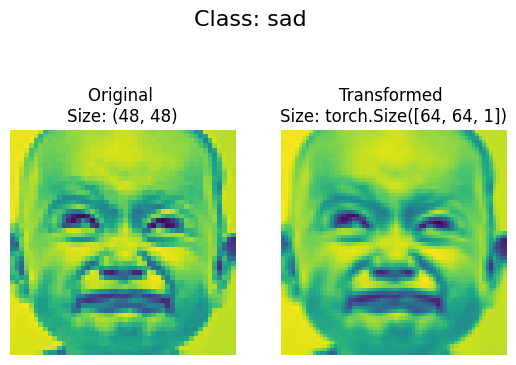

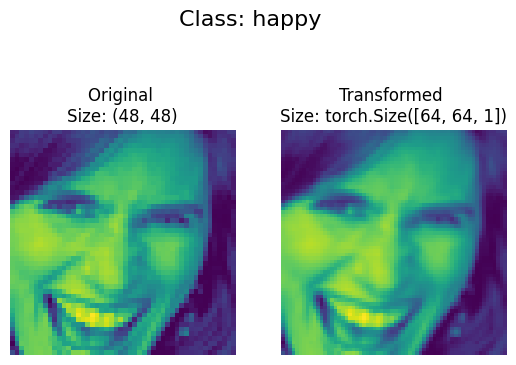

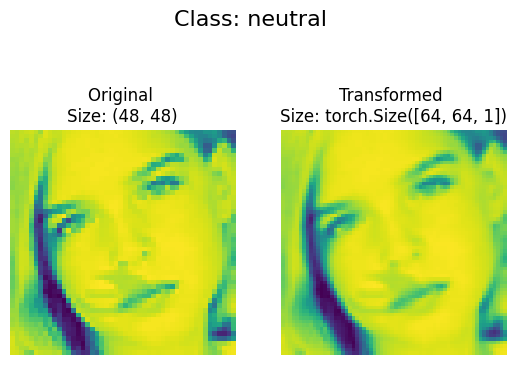

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)

In [10]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 32633
    Root location: data/faces/data/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 8123
    Root location: data/faces/data/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )


In [11]:
# Get class names as a list
class_names = train_data.classes
class_names

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

In [12]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'angry': 0,
 'disgusted': 1,
 'fearful': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprised': 6}

In [13]:
# Check the lengths
len(train_data), len(test_data)

(32633, 8123)

In [14]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image shape: torch.Size([3, 64, 64])
Image datatype: torch.float32
Image label: 0
Label datatype: <class 'int'>


In [15]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=32,
                              num_workers=1, 
                              shuffle=True) 

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=32, 
                             num_workers=1, 
                             shuffle=False) 

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7ff392be5ff0>,
 <torch.utils.data.dataloader.DataLoader at 0x7ff392b97e20>)

In [16]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


In [17]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*/*.png"))

In [18]:
class EmotionDetection(nn.Module):
  
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3,
                      stride=1, 
                      padding=1),
            nn.BatchNorm2d(hidden_units),  
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) 
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=128),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(in_features=128,
                      out_features=64),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=64,
                      out_features=output_shape),
            nn.Dropout(p=0.2)
        )
    
    def forward(self, x: torch.Tensor):
      # return self.classifier(self.conv_block_1(x)) 
      return self.classifier(self.conv_block_2(self.conv_block_1(x))) 

torch.manual_seed(42)
model = EmotionDetection(input_shape=3,
                  hidden_units=64, 
                  output_shape=len(train_data.classes)).to(device)
model

EmotionDetection(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Dropout(p=0.3, inplace=False)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=16384, out_features=128, bias=True)
    

In [19]:
# from torchvision.models import resnet50, ResNet50_Weights

# # Using pretrained weights:
# resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
# resnet50(weights="IMAGENET1K_V1")
# resnet50(pretrained=True)  # deprecated
# resnet50(True)  # deprecated

# # # Using no weights:
# # resnet50(weights=None)
# # resnet50()
# # resnet50(pretrained=False)  # deprecated
# # resnet50(False)  # deprecated

In [20]:
# # Initialize model
# weights = ResNet50_Weights.IMAGENET1K_V1
# model = resnet50(weights=weights)


In [21]:
# Install torchinfo if it's not available, import it if it is
try: 
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
    
from torchinfo import summary
summary(model, input_size=[1, 3, 64, 64])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Layer (type:depth-idx)                   Output Shape              Param #
EmotionDetection                         [1, 7]                    --
├─Sequential: 1-1                        [1, 64, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 64, 64, 64]           1,792
│    └─BatchNorm2d: 2-2                  [1, 64, 64, 64]           128
│    └─ReLU: 2-3                         [1, 64, 64, 64]           --
│    └─Dropout: 2-4                      [1, 64, 64, 64]           --
│    └─Conv2d: 2-5                       [1, 64, 64, 64]           36,928
│    └─ReLU: 2-6                         [1, 64, 64, 64]           --
│    └─Dropout: 2-7                      [1, 64, 64, 64]           --
│    └─MaxPool2d: 2-8                    [1, 64, 32, 32]           --
├─Sequential: 1-2                        [1, 64, 16, 16]           --
│    └─Conv2d: 2-9                       [1, 64, 32, 32]           36,928
│    └─ReLU: 2-10                        [1, 64, 32, 32]           --
│  

In [22]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [23]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [24]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [25]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 30


# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

# Train model_0 
model_results = train(model=model, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.8348 | train_acc: 0.2598 | test_loss: 1.6822 | test_acc: 0.3912
Epoch: 2 | train_loss: 1.6240 | train_acc: 0.3688 | test_loss: 1.5507 | test_acc: 0.4475
Epoch: 3 | train_loss: 1.5027 | train_acc: 0.4197 | test_loss: 1.4759 | test_acc: 0.4528
Epoch: 4 | train_loss: 1.4362 | train_acc: 0.4429 | test_loss: 1.4915 | test_acc: 0.4656
Epoch: 5 | train_loss: 1.3946 | train_acc: 0.4604 | test_loss: 1.4810 | test_acc: 0.4613
Epoch: 6 | train_loss: 1.3584 | train_acc: 0.4695 | test_loss: 1.4432 | test_acc: 0.4779
Epoch: 7 | train_loss: 1.3278 | train_acc: 0.4804 | test_loss: 1.4509 | test_acc: 0.4725
Epoch: 8 | train_loss: 1.3091 | train_acc: 0.4888 | test_loss: 1.4611 | test_acc: 0.4821
Epoch: 9 | train_loss: 1.2899 | train_acc: 0.4923 | test_loss: 1.4366 | test_acc: 0.4792
Epoch: 10 | train_loss: 1.2738 | train_acc: 0.5025 | test_loss: 1.4562 | test_acc: 0.4882
Epoch: 11 | train_loss: 1.2498 | train_acc: 0.5117 | test_loss: 1.4392 | test_acc: 0.4805
Epoch: 12 | train_l

In [26]:
from typing import Tuple, Dict, List
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

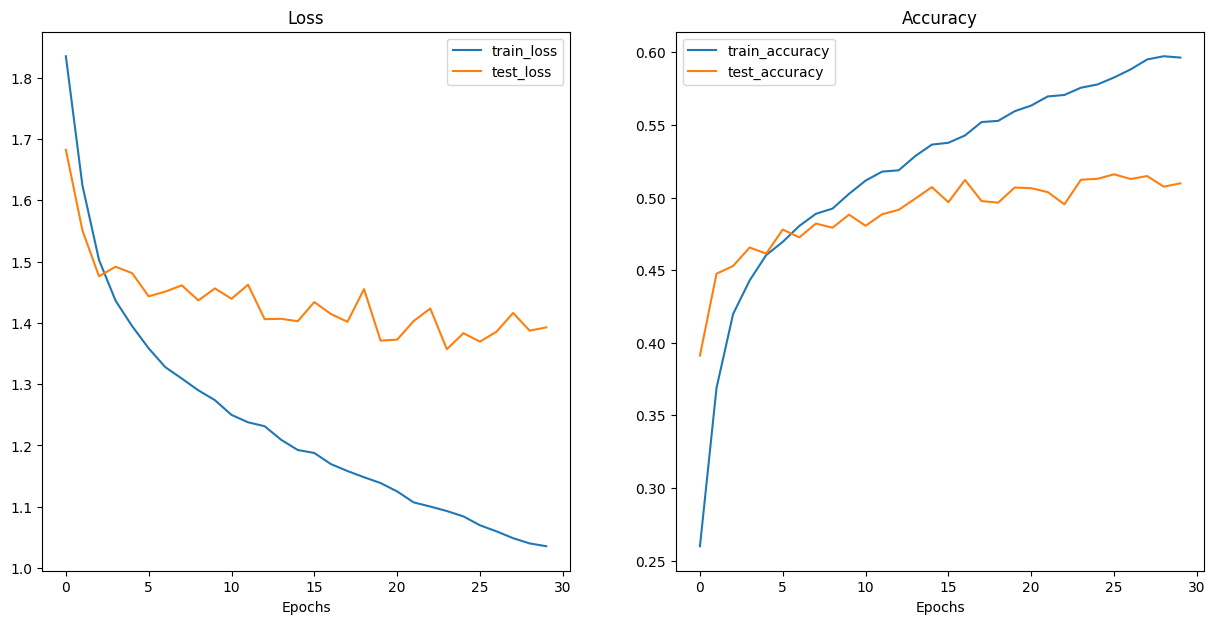

In [27]:
plot_loss_curves(model_results)

In [28]:
# torch.save(model, 'model.pth')

In [29]:
torch.save(model.state_dict(), 'model_weights.pth')